In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from minitorch import module, autodiff
from minitorch.optim import SGDOptimizer
import minitorch.datasets as data
import minitorch.autodiff.tensor_functions as tf
import minitorch.tensor_losses as tl
import minitorch.tensor_metrics as tm
import minitorch.tensor_plotting as tp

In [2]:
# Define data
N_SAMPLES = 100
datasets = {
    "simple": data.SimpleDataset,
    "diagonal": data.DiagonalDataset,
    "split": data.SplitDataset,
    "xor": data.XORDataset
}

# Define networks configs
N_EPOCHS = 100
LR = {
    "simple": 0.3,
    "diagonal": 0.3,
    "split": 0.5,
    "xor": 0.5
}
NETWORK_DIMS = {
    "simple": (2, 5, 1),
    "diagonal": (2, 5, 1),
    "split": (2, 10, 1),
    "xor": (2, 10, 1)
}

# Placeholders for losses and metrics
losses = {}
roc_curves = {}
trained_classifiers = {}

for dataset_type, dataset_cls in datasets.items():
    
    print("====================================")
    print(f"Training on dataset: {dataset_type}")
    print("====================================")
    
    losses[dataset_type] = []
    roc_curves[dataset_type] = []
    
    for _ in tqdm(range(25)):

        # Get data
        dataset = dataset_cls(N_SAMPLES)
        X = tf.tensor([list(x) for x in dataset.xs], backend=autodiff.FastBackend)
        y_true = tf.tensor(dataset.ys, backend=autodiff.FastBackend).view(N_SAMPLES, 1)

        # Train classifier
        network = module.TensorNetwork(*NETWORK_DIMS[dataset_type], backend=autodiff.FastBackend)
        optimizer = SGDOptimizer(network.parameters(), lr=LR[dataset_type])
        losses_for_dataset = network.fit_binary_classifier(X, y_true, optimizer, N_EPOCHS, logging_freq=N_EPOCHS + 1)
        losses[dataset_type].append(losses_for_dataset)

        # Metrics
        y_hat = network.forward(X).sigmoid().view(N_SAMPLES)
        y_true = y_true.view(N_SAMPLES)
        tpr, fpr, _ = tm.roc_curve(y_true, y_hat)
        roc_curves[dataset_type].append((tpr, fpr))

    # Save the last trained network
    trained_classifiers[dataset_type] = network
    



Training on dataset: simple


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


Training on dataset: diagonal


100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


Training on dataset: split


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


Training on dataset: xor


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


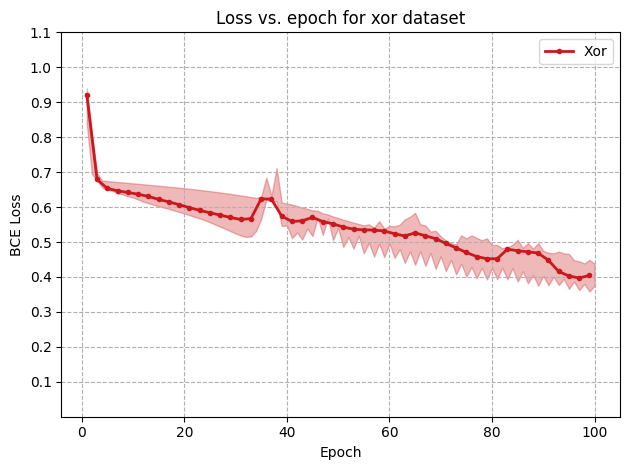

In [9]:
# Plot losses
fig, ax = plt.subplots(1, 1)

dataset_type= "xor"
dataset_types = list(datasets.keys())
colors = np.linspace(0.25, 0.75, len(datasets))

ax.plot(
    np.arange(1, N_EPOCHS + 1, 2),
    np.median(np.array(losses[dataset_type]), axis=0)[::2],
    label=dataset_type.capitalize(),
    color=matplotlib.cm.get_cmap("Reds")(colors[dataset_types.index(dataset_type)]),
    marker="o",
    markersize=3,
    lw=2
)
ax.fill_between(
    np.arange(1, N_EPOCHS + 1),
    np.quantile(np.array(losses[dataset_type]), q= 0.25, axis=0),
    np.quantile(np.array(losses[dataset_type]), q= 0.75, axis=0),
    color=matplotlib.cm.get_cmap("Reds")(colors[dataset_types.index(dataset_type)]),
    alpha=0.3
)

ax.set_ylabel("BCE Loss")
ax.set_xlabel("Epoch")
ax.set_title(f"Loss vs. epoch for {dataset_type} dataset")

ax.legend()
ax.set_ylim(0.0, 1.1,)
ax.set_yticks(np.linspace(0.1, 1.1, 11))
ax.grid("on", ls="--")


fig.tight_layout();

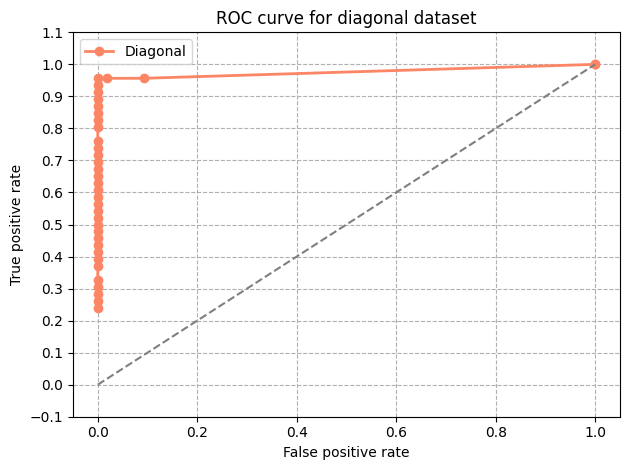

In [4]:
# Plot ROC
fig, ax = plt.subplots(1, 1)

run_idx = 0
dataset_type= "diagonal"
dataset_types = list(datasets.keys())
colors = np.linspace(0.25, 0.75, len(datasets))

ax.plot(
    np.array(roc_curves[dataset_type][run_idx][1].data.storage),
    np.array(roc_curves[dataset_type][run_idx][0].data.storage),
    label=dataset_type.capitalize(),
    color=matplotlib.cm.get_cmap("Reds")(colors[dataset_types.index(dataset_type)]),
    marker="o",
    lw=2
)
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")

ax.set_ylabel("True positive rate")
ax.set_xlabel("False positive rate")
ax.set_title(f"ROC curve for {dataset_type} dataset")

ax.legend()
ax.set_ylim(-0.1, 1.1,)
ax.set_yticks(np.linspace(-0.1, 1.1, 13))
ax.grid("on", ls="--")

fig.tight_layout();


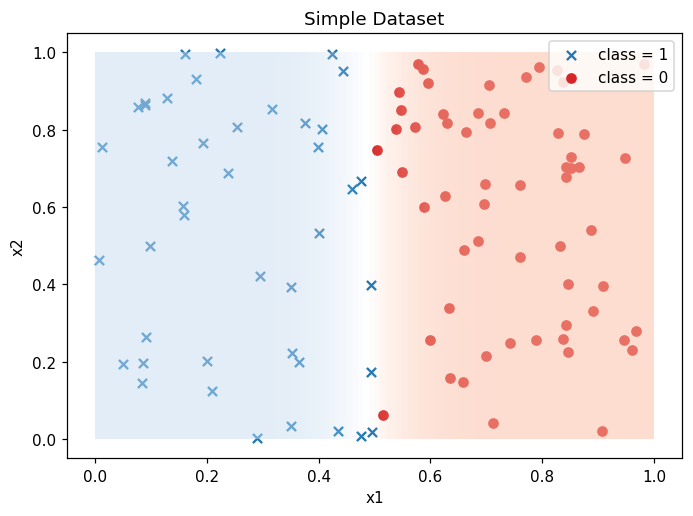

In [5]:
dataset_type = "simple"
dataset_types = list(datasets.keys())

tp.plot_tensor_predictions(
    datasets[dataset_type](N_SAMPLES), 
    trained_classifiers[dataset_type],
    matplotlib.cm.get_cmap("Blues")(colors[dataset_types.index(dataset_type)]),
    matplotlib.cm.get_cmap("Reds")(colors[dataset_types.index(dataset_type)]),
    
);